In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp

We Improve on the energy calculation by only calcualting the difference in energy between two states, rather than calculating the energy for the entire state

In [8]:
def energy(state, J):
    L = state.shape[0]
    e = 0.0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

def neighbor_sum(state, i, j, k):
    L = state.shape[0]
    return (
        state[(i + 1) % L, j, k] +
        state[(i - 1) % L, j, k] +
        state[i, (j + 1) % L, k] +
        state[i, (j - 1) % L, k] +
        state[i, j, (k + 1) % L] +
        state[i, j, (k - 1) % L]
    )

def local_deltaE(state, i, j, k, J):
    s = state[i, j, k]
    nn = neighbor_sum(state, i, j, k)
    return 2.0 * J * s * nn


In [9]:
def metropolis(e_old, e_new, T):
    if e_new < e_old:
        return True
    else:
        if np.random.random() < exp((e_old - e_new) / T):
            return True
        return False
    
def flip(state, i, j, k):
    state[i, j, k] = -state[i, j, k]

def magnetization(state):
    return np.sum(state) / state.size

We implement Wolff's method here, so we can compare it to Metropolis'. Wolff step calcualtes which molecuels to switch, wolff sweep flips the entire cluster that was returned by Wollf step

### Wolff cluster update

The standard single–spin Metropolis update becomes very inefficient near the critical temperature $T_c$ Large domains of aligned spins form, and flipping a single spin inside such a domain usually costs a large positive $\Delta E$, so the Metropolis acceptance
$$
p_{\text{acc}} = \min\left(1, e^{-\beta \Delta E}\right), \quad \beta = \frac{1}{T},
$$
is tiny. The result is **critical slowing down**: configurations change very slowly and autocorrelation times blow up.

The **Wolff algorithm** fixes this by flipping entire **clusters of aligned spins** in one move. For the 3D Ising model (same Hamiltonian as above, just with 6 nearest neighbours), one Wolff update is:

1. **Seed selection**  
   Pick a random lattice site $ i_0 $ and set $s_0 = s_{i_0}$.  
   Initialize the cluster
   $$
   C = \{ i_0 \}.
   $$

2. **Cluster growth**  
   For each site $i \in C$ consider each of its 6 nearest neighbours $j\$
   - If $s_j = s_0$(parallel spin), add $j\o$ the cluster with probability
     $$
     P_{\text{add}} = 1 - e^{-2 \beta J}.
     $$
   - Newly added sites are treated in the same way.  
   - Repeat until no new spins are added.

3. **Cluster flip**  
   Flip all spins in the cluster:
   $$
   s_i \to -s_i \quad \forall\, i \in C.
   $$

This single cluster flip replaces many single–spin flips and acts as a **non-local move** in configuration space. At high $T$ $P_{\text{add}}$is small and clusters stay small; near $T_c$ clusters grow large and entire domains can flip at once.

The specific choice
$$
P_{\text{add}} = 1 - e^{-2 \beta J}
$$
is made so that the **construction probability of a given cluster** already carries the correct Boltzmann weighting. With this choice, flipping the whole cluster can be accepted with probability 1; detailed balance with respect to the Ising Hamiltonian is satisfied purely through the cluster growth rule. In practice, this drastically reduces critical slowing down compared to local Metropolis updates, especially in 3D near the phase transition.


In [ ]:
def wolff_step(state, T, J):
    """
    Perform ONE Wolff cluster flip.
    Returns the cluster size (for diagnostics), but does NOT compute dE.
    """
    L = state.shape[0]
    beta = 1.0 / T
    p_add = 1.0 - exp(-2.0 * beta * J)

    i0 = np.random.randint(0, L)
    j0 = np.random.randint(0, L)
    k0 = np.random.randint(0, L)
    spin0 = state[i0, j0, k0]

    visited = np.zeros_like(state, dtype=bool)
    stack = [(i0, j0, k0)]
    visited[i0, j0, k0] = True
    cluster = []

    while stack:
        i, j, k = stack.pop()
        cluster.append((i, j, k))

        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )

        for ni, nj, nk in neighbours:
            if visited[ni, nj, nk]:
                continue

            if state[ni, nj, nk] == spin0:
                if np.random.random() < p_add:
                    visited[ni, nj, nk] = True
                    stack.append((ni, nj, nk))

    for (i, j, k) in cluster:
        state[i, j, k] = -state[i, j, k]

    return len(cluster)

import numpy as np
from math import exp

def wolff_step_with_deltaE(state, T, J):
    """
    Perform ONE Wolff cluster flip.
    Returns:
        cluster_size, deltaE
    where deltaE is the energy change due to the cluster flip.
    """
    L = state.shape[0]
    beta = 1.0 / T
    p_add = 1.0 - exp(-2.0 * beta * J)

    # 1. Seed
    i0 = np.random.randint(0, L)
    j0 = np.random.randint(0, L)
    k0 = np.random.randint(0, L)
    spin0 = state[i0, j0, k0]

    visited = np.zeros_like(state, dtype=bool)
    stack = [(i0, j0, k0)]
    visited[i0, j0, k0] = True
    cluster = []

    # 2. Grow cluster
    while stack:
        i, j, k = stack.pop()
        cluster.append((i, j, k))

        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )

        for ni, nj, nk in neighbours:
            if visited[ni, nj, nk]:
                continue

            if state[ni, nj, nk] == spin0:
                if np.random.random() < p_add:
                    visited[ni, nj, nk] = True
                    stack.append((ni, nj, nk))

    deltaE = 0.0
    for (i, j, k) in cluster:
        s = state[i, j, k]
        neighbours = (
            ((i + 1) % L, j, k), ((i - 1) % L, j, k),
            (i, (j + 1) % L, k), (i, (j - 1) % L, k),
            (i, j, (k + 1) % L), (i, j, (k - 1) % L),
        )
        for ni, nj, nk in neighbours:
            if not visited[ni, nj, nk]:
                deltaE += 2.0 * J * s * state[ni, nj, nk]

    for (i, j, k) in cluster:
        state[i, j, k] = -state[i, j, k]

    return len(cluster), deltaE





In [21]:
side = 10
t = 2
J = 1.0  
nstep = 50000
seed = 42  
state = 2 * np.random.randint(2, size=(side, side, side)) - 1
np.random.seed(seed)

Here we create a function to run the dynamics, where we can change which method we want to use (Metroplis vs Wolff). For the Wolff implementation, we decided to revert back to calculating the entire energy of the system, as trying to model the Delta E was causing more trouble than it was worth.

In [34]:

def run_dynamics(state, J, T, nstep, algo="metropolis", efficient = True):
    """
    Run nstep Monte Carlo steps with either Metropolis or Wolff.
    """
    L = state.shape[0]

    e_old = energy(state, J)

    e_history = []
    m_history = []

    for istep in range(nstep):
        if algo == "metropolis":
            i = np.random.randint(L)
            j = np.random.randint(L)
            k = np.random.randint(L)

            dE = local_deltaE(state, i, j, k, J)
            e_new = e_old + dE

            if metropolis(e_old, e_new, T):
                flip(state, i, j, k)
                e_old = e_new

        elif algo == "wolff":
            if efficient:
                cluster_size, dE = wolff_step_with_deltaE(state, T, J)
                e_old += dE
            else:
                cluster_size = wolff_step(state, T, J)
                e_old = energy(state, J)
            #e_new = e_old + dE
            #e_old = e_new
            #e_old = energy(state, J)



        else:
            raise ValueError("algo must be 'metropolis' or 'wolff'")

        e_history.append(e_old)
        m_history.append(magnetization(state))

    return e_history, m_history

In [35]:
#e_history, m_history = run_dynamics(state, J, t, nstep, algo="metropolis")
import time 
tot = time.time()
e_history, m_history = run_dynamics(state, J, t, nstep, algo="wolff")
print("efficient took: ",time.time()-tot)
tot = time.time()
e_history, m_history = run_dynamics(state, J, t, nstep, algo="wolff", efficient=False)
print("non efficient took: ", time.time()-tot)

efficient took:  119.10990190505981
non efficient took:  262.98379921913147


In [ ]:
# discard first 1/3 of samples
cut = int(nstep/3)
e_sel = e_history[cut:]
m_sel = m_history[cut:]

avE = np.mean(e_sel)
avM = np.mean(m_sel)

print("Average energy:", avE)
print("Average magnetization:", avM)


Average energy: -22.971260574788506
Average magnetization: 0.014840823183536331


<>:105: SyntaxWarning: invalid escape sequence '\s'
<>:105: SyntaxWarning: invalid escape sequence '\s'
C:\Users\leona\AppData\Local\Temp\ipykernel_22180\1748930180.py:105: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(x=4.51, color='gray', linestyle=':', label='$T_c \sim 4.51$ (Expected)')


Starting Scan (L=10x10x10, J=1.0). Steps/T: 10000 (Thermalization: 3000)
T=3.00 done. <|m|>=0.9458
T=3.05 done. <|m|>=0.9414
T=3.10 done. <|m|>=0.9362
T=3.15 done. <|m|>=0.9307
T=3.20 done. <|m|>=0.9243
T=3.25 done. <|m|>=0.9190
T=3.30 done. <|m|>=0.9116
T=3.35 done. <|m|>=0.9046
T=3.40 done. <|m|>=0.8974
T=3.45 done. <|m|>=0.8895
T=3.50 done. <|m|>=0.8811
T=3.55 done. <|m|>=0.8720
T=3.60 done. <|m|>=0.8619
T=3.65 done. <|m|>=0.8518
T=3.70 done. <|m|>=0.8396
T=3.75 done. <|m|>=0.8281
T=3.80 done. <|m|>=0.8149
T=3.85 done. <|m|>=0.7993
T=3.90 done. <|m|>=0.7867
T=3.95 done. <|m|>=0.7695
T=4.00 done. <|m|>=0.7497
T=4.05 done. <|m|>=0.7316
T=4.10 done. <|m|>=0.7111
T=4.15 done. <|m|>=0.6851
T=4.20 done. <|m|>=0.6596
T=4.25 done. <|m|>=0.6252
T=4.30 done. <|m|>=0.5829
T=4.35 done. <|m|>=0.5397
T=4.40 done. <|m|>=0.4795
T=4.45 done. <|m|>=0.4153
T=4.50 done. <|m|>=0.3411
T=4.55 done. <|m|>=0.2932
T=4.60 done. <|m|>=0.2467
T=4.65 done. <|m|>=0.2014
T=4.70 done. <|m|>=0.1824
T=4.75 done. <|m|

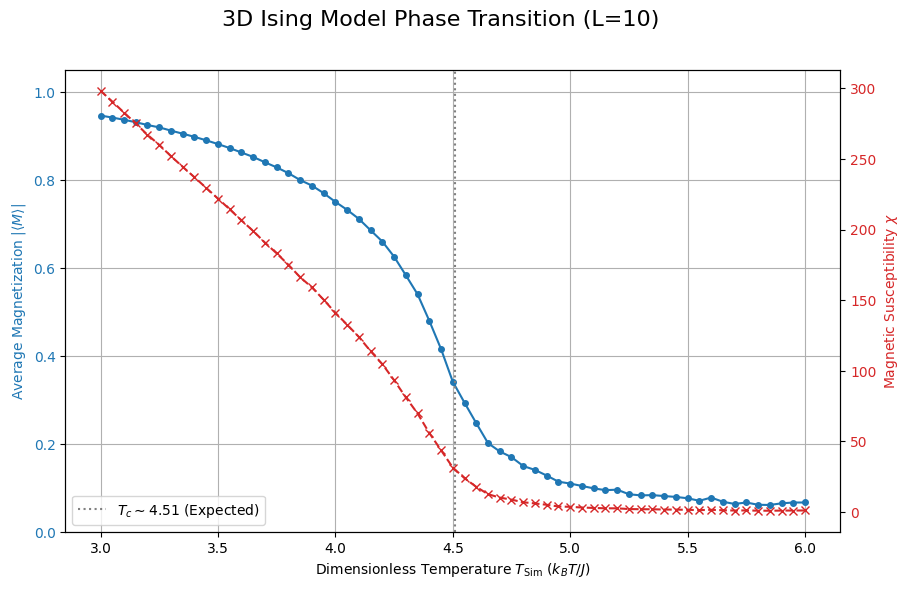


--- Interpretation ---
1. Find the Critical Temperature (Tc) of your model where the Magnetization drops to zero and the Susceptibility (red line) peaks.
2. Use this value (T_c_model) to calculate J_effective using: J_effective = (k_B * T_c_Iron) / T_c_model


In [37]:
def temperature_scan(L, J, T_min, T_max, T_step,
                     N_steps_total, N_therm_ratio,
                     algo="wolff"):
    """
    Scan temperature and measure:
      - <|m|>  (order parameter)
      - chi(T) = (N/T) * ( <m^2> - <m>^2 )

    Uses the current run_dynamics(state, J, T, nstep, algo=...) implementation.
    """
    # Temperature grid
    Ts = np.arange(T_min, T_max + T_step, T_step)

    M_abs_avg = []   # <|m|>
    Chi_avg   = []   # susceptibility

    # Number of steps to discard as thermalization
    N_therm = int(N_steps_total * N_therm_ratio)

    # One random initial configuration (copied for each T)
    initial_state = 2 * np.random.randint(2, size=(L, L, L)) - 1

    print(f"Starting Scan (L={L}x{L}x{L}, J={J}). "
          f"Steps/T: {N_steps_total} (Thermalization: {N_therm})")

    for T in Ts:
        # Start from the same random configuration at each T
        state = initial_state.copy()

        # NOTE: argument order: (state, J, T, nstep, algo=...)
        e_history, m_history = run_dynamics(state, J, T, N_steps_total, algo=algo)

        m_history = np.array(m_history, dtype=float)

        # Discard thermalization
        m_eq = m_history[N_therm:]

        # What you *plot* as the order parameter: <|m|>
        m_abs_mean = np.mean(np.abs(m_eq))

        # What you use for susceptibility: signed m
        m_mean  = np.mean(m_eq)
        m2_mean = np.mean(m_eq**2)

        # N = number of spins
        N = L**3
        chi = (N / T) * (m2_mean - m_mean**2)

        M_abs_avg.append(m_abs_mean)
        Chi_avg.append(chi)

        print(f"T={T:.2f} done. <|m|>={m_abs_mean:.4f}")

    return Ts, M_abs_avg, Chi_avg


# --- Execution ---

# Configuration
LATTICE_SIZE = 10
J_VAL = 1.0 
T_START = 3.0
T_END = 6.0
T_STEP = 0.05 # Fine steps give a better curve
TOTAL_STEPS = 10000 
THERMALIZATION_RATIO = 0.3 # Discard first 30% of steps

# Run the experiment
Ts, M_vals, Chi_vals = temperature_scan(
    LATTICE_SIZE,
    J_VAL,
    T_START,
    T_END,
    T_STEP,
    TOTAL_STEPS,
    THERMALIZATION_RATIO,
    algo="wolff"   # or "metropolis" if you want to compare
)

Tc_index = np.argmax(Chi_vals)
Tc_model = Ts[Tc_index]
print("Model Tc ~", Tc_model)
# --- Plotting Results ---

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.suptitle(f'3D Ising Model Phase Transition (L={LATTICE_SIZE})', fontsize=16)

# Plot Magnetization (|M|) on the left axis
color = 'tab:blue'
ax1.set_xlabel(r'Dimensionless Temperature $T_{\text{Sim}}$ ($k_B T/J$)')
ax1.set_ylabel(r'Average Magnetization $|\langle M \rangle|$', color=color)
ax1.plot(Ts, M_vals, color=color, marker='o', markersize=4, linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.set_ylim(0, 1.05) # M cannot exceed 1

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel(r'Magnetic Susceptibility $\chi$', color=color)  
ax2.plot(Ts, Chi_vals, color=color, marker='x', markersize=6, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Add an estimate for the known Tc (4.51)
ax1.axvline(x=4.51, color='gray', linestyle=':', label='$T_c \sim 4.51$ (Expected)')
ax1.legend(loc='lower left')

plt.show()

# --- Interpretation Prompt ---
print("\n--- Interpretation ---")
print("1. Find the Critical Temperature (Tc) of your model where the Magnetization drops to zero and the Susceptibility (red line) peaks.")
print("2. Use this value (T_c_model) to calculate J_effective using: J_effective = (k_B * T_c_Iron) / T_c_model")